In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker 
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import mlab
import scipy.interpolate as spi
from scipy import stats

# Read the monthly O3 

### Ozone forcing HIST

In [2]:
%cd /gxfs_work1/geomar/smomw418/models/foci/experiments
hist_o3 = xr.open_dataset('FOCI1.14-SW079_echam6_echam_1850-2099_ao3_pl.nc', decode_times=True)
hist_o3 = hist_o3.sel(time=slice('1958-01-01', '2002-12-31'))

/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments


### FOCI-MOZ

In [3]:
%cd sw054
sw054_o3 = xr.open_dataset('FOCI1.4-SW054_echam6_alltrm_1954-2013_O3_pl.nc', decode_times=True)
sw054_o3 = sw054_o3.sel(time=slice('1958-01-01', '2002-12-31'))
%cd sw064
sw064_o3 = xr.open_dataset('FOCI1.4-SW064_echam6_alltrm_1952-2013_O3_pl.nc', decode_times=True)
sw064_o3 = sw064_o3.sel(time=slice('1958-01-01', '2002-12-31'))
%cd sw065
sw065_o3 = xr.open_dataset('FOCI1.4-SW065_echam6_alltrm_1950-2013_O3_pl.nc', decode_times=True)
sw065_o3 = sw065_o3.sel(time=slice('1958-01-01', '2002-12-31'))

(bookmark:sw054) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
(bookmark:sw064) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
(bookmark:sw065) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6


In [4]:
# Make sure all have the same lat
sw064_o3 = sw064_o3.assign_coords(lat=sw054_o3.lat)
sw065_o3 = sw065_o3.assign_coords(lat=sw054_o3.lat)
hist_o3 = hist_o3.assign_coords(lat=sw054_o3.lat)

## Define function to compute volume mixing ratio (ppmv) 

In [5]:
def vmr(ozone):
    # Input: ozone -> O3 mass mixing ratio in kg/kg

    # Convert from kg/kg to microg/g (multiply by 10^6)
    m = ozone*1e6
    # Convert the mass mixing ratio to volume mixing ratio in ppmv
    vmr = m*(28.9644/47.9982) # approx 0.603
    
    return vmr

## Compute volume mixing ratio (in ppmv)

In [6]:
sw054_o3

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 192, plev: 26, time: 540)
Coordinates:
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float32 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 7.75e+04 ... 50.0 20.0 10.0
  * time     (time) datetime64[ns] 1958-01-31T23:52:00 ... 2002-12-31T23:52:00
Data variables:
    O3       (time, plev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed Mar 07 08:43:05 2018: cdo -t /gfs2/work/shkifmsw/models...
    CDO:          Climate Data Operators version 1.9.0 (http://mpimet.mpg.de/...

In [7]:
sw054_vmr = vmr(sw054_o3.O3)
sw064_vmr = vmr(sw064_o3.O3)
sw065_vmr = vmr(sw065_o3.O3)

hist_vmr = vmr(hist_o3.ao3)

## Compute ensemble means

In [8]:
sw065_vmr = sw065_vmr.rename({'lev': 'plev'})

In [9]:
moz_vmr = xr.concat((sw054_vmr, sw064_vmr, sw065_vmr), dim='exp').mean(dim='exp')

In [10]:
moz_vmr = moz_vmr.sel(plev=slice(20000, 5000), lat=slice(-18,-90))
hist_vmr = hist_vmr.sel(plev=slice(20000, 5000), lat=slice(-18,-90))

In [11]:
def mann_kendall(data):
    
    time = data.year
    plev = data.plev
    lat = data.lat
    lon = data.lon
    month = data.month
    trend = xr.DataArray(np.zeros((len(month), len(plev), len(lat), len(lon))), \
                         dims=['month', 'plev','lat', 'lon'], coords = [month, plev, lat, lon])
    
    for i in range(0, len(time)-1):
        val = data.sel(year=time[i]) # select each value in the array
        sign = xr.where(data>val, 1, 2) # put 1 where following values are greater than val
        sign = xr.where(data<val, -1, sign) # put -1 where following values are smaller than val
        sign = xr.where(data==val, 0, sign) # put 0 where following values are equal to val
        trend = trend + sign[:,i+1::,:,:,:].sum(dim='year')
        no_equal = sign.where(sign==0).count(dim='year')-1
    
    # Compute the variance
    var = 1/18*(len(time)*(len(time)-1)*(2*len(time)+5))
    
    # Compute the normalized test statistic
    z = xr.where(trend>0, (trend-1)/np.sqrt(var), 0)
    z = xr.where(trend<0, (trend+1)/np.sqrt(var), z)
    
    # Compute the probability associated with the test statistic
    p = 1/np.sqrt(2*np.pi)*np.exp(z**2/(-2))
    
    # Form array with 1 where the trend is significant and 0 elsewhere
    signif = xr.where(p<0.05, 1, 0)
    
    return signif

In [12]:
def ii_sel_months(data):
    #----------------------------------------select each calendar month and average over it for each year----------------------------------
    # Input: data = xarray containing the data
    # Output: an array with yearly timeseries for each month
    # Author: Ioana Ivanciu (27.10.2018)
    #------------------------------------------------------------------------------------------------------------------------------
    
    import xarray as xr
    
    # Define boolean masks for each month
    def is_jan(month):
        return month==1 # returns an array with true where the month is in Jan and false elswhere
    def is_feb(month):
        return month==2
    def is_mar(month):
        return month==3
    def is_apr(month):
        return month==4
    def is_may(month):
        return month==5
    def is_jun(month):
        return month==6
    def is_jul(month):
        return month==7
    def is_aug(month):
        return month==8
    def is_sep(month):
        return month==9
    def is_oct(month):
        return month==10
    def is_nov(month):
        return month==11
    def is_dec(month):
        return month==12
    
    
    # Select each mon and average it over each year
    data_jan = data.sel(time=is_jan(data['time.month'])).groupby('time.year').mean(dim='time')
    data_feb = data.sel(time=is_feb(data['time.month'])).groupby('time.year').mean(dim='time')
    data_mar = data.sel(time=is_mar(data['time.month'])).groupby('time.year').mean(dim='time')
    data_apr = data.sel(time=is_apr(data['time.month'])).groupby('time.year').mean(dim='time')
    data_may = data.sel(time=is_may(data['time.month'])).groupby('time.year').mean(dim='time')
    data_jun = data.sel(time=is_jun(data['time.month'])).groupby('time.year').mean(dim='time')
    data_jul = data.sel(time=is_jul(data['time.month'])).groupby('time.year').mean(dim='time')
    data_aug = data.sel(time=is_aug(data['time.month'])).groupby('time.year').mean(dim='time')
    data_sep = data.sel(time=is_sep(data['time.month'])).groupby('time.year').mean(dim='time')
    data_oct = data.sel(time=is_oct(data['time.month'])).groupby('time.year').mean(dim='time')
    data_nov = data.sel(time=is_nov(data['time.month'])).groupby('time.year').mean(dim='time')
    data_dec = data.sel(time=is_dec(data['time.month'])).groupby('time.year').mean(dim='time')
    
    data_mon = xr.concat([data_jan, data_feb, data_mar, data_apr, data_may, data_jun, data_jul, data_aug, data_sep, data_oct, data_nov, data_dec], 'month')
    
    return data_mon


In [13]:
def ii_trend_mon_plev(data):
       
    mon = ii_sel_months(data)
    
    # Compute the linear trend using least squares method
    time = mon.year
    t = np.arange(1,len(time)+1)
    trend = np.zeros((len(mon.month), len(mon.plev), len(mon.lat), len(mon.lon)))
    for i in range(0, len(mon.lat)):
        for k in range(0, len(mon.lon)):
            for j in range(0, len(mon.month)):
                for p in range(0, len(mon.plev)):
                    trend[j,p,i,k], _, _, _, _ = stats.linregress(t, mon[j,:,p,i,k].values) # linear regression of x from time
            
    trend = xr.DataArray(trend*10, dims=['month', 'plev', 'lat', 'lon'], coords=[mon.month, mon.plev, mon.lat, mon.lon])

    # Check the significance using the Mann-Kendall test
    sig = mann_kendall(mon) #1 where the trend is significant and 0 elsewhere

    signif = xr.where(sig==1, trend, np.nan)
    non_sig = xr.where(sig==0, 1, np.nan)
    
    # Compute the time mean for each month
    mean = mon.mean(dim='year')
    
    return trend, signif, mean

In [14]:
moz_trend, moz_sign, moz_mean = ii_trend_mon_plev(moz_vmr)
hist_trend, hist_sign, hist_mean = ii_trend_mon_plev(hist_vmr)

## Read the daily temperature

### FOCI-HIST

In [15]:
%cd -b sw060
sw060 = xr.open_dataset('FOCI1.7-SW060_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
sw060 = sw060.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
%cd -b sw061
sw061 = xr.open_dataset('FOCI1.7-SW061_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
sw061 = sw061.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
%cd -b jh019
jh019 = xr.open_dataset('FOCI1.9.4-JH019_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
jh019 = jh019.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))

(bookmark:sw060) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.7-SW060/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW060/outdata/echam6
(bookmark:sw061) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.7-SW061/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW061/outdata/echam6
(bookmark:jh019) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.9.4-JH019/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.9.4-JH019/outdata/echam6


### FOCI-MOZ

In [16]:
%cd -b sw054
sw054 = xr.open_dataset('FOCI1.4-SW054_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
sw054 = sw054.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
%cd -b sw064
sw064 = xr.open_dataset('FOCI1.4-SW064_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
sw064 = sw064.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
%cd -b sw065
sw065 = xr.open_dataset('FOCI1.4-SW065_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
sw065 = sw065.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))

(bookmark:sw054) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
(bookmark:sw064) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
(bookmark:sw065) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6


In [17]:
moz_t = xr.concat((sw054.st, sw064.st, sw065.st), dim='exp').mean(dim='exp')
hist_t = xr.concat((sw060.st, sw061.st, jh019.st), dim='exp').mean(dim='exp')

In [18]:
moz_trend_t, moz_sign_t, moz_mean_t = ii_trend_mon_plev(moz_t)
hist_trend_t, hist_sign_t, hist_mean_t = ii_trend_mon_plev(hist_t)

In [19]:
sw054_trend_t, sw054_sign_t, sw054_mean_t = ii_trend_mon_plev(sw054.st)
sw064_trend_t, sw064_sign_t, sw064_mean_t = ii_trend_mon_plev(sw064.st)
sw065_trend_t, sw065_sign_t, sw065_mean_t = ii_trend_mon_plev(sw065.st)

In [20]:
sw060_trend_t, sw060_sign_t, sw060_mean_t = ii_trend_mon_plev(sw060.st)
sw061_trend_t, sw061_sign_t, sw061_mean_t = ii_trend_mon_plev(sw061.st)
jh019_trend_t, jh019_sign_t, jh019_mean_t = ii_trend_mon_plev(jh019.st)

## Read the daily heating rates

### FOCI-HIST

In [21]:
%cd -b sw060
sw060_sw = xr.open_dataset('FOCI1.7-SW060_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl.nc', decode_times=True)
sw060_sw = sw060_sw.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
sw060_dyn = xr.open_dataset('FOCI1.7-SW060_echam6_tdiag_1958-2013_dtdt_rheat_Q_dyn.nc', decode_times=True)
sw060_dyn = sw060_dyn.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
%cd -b sw061
sw061_sw = xr.open_dataset('FOCI1.7-SW061_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl.nc', decode_times=True)
sw061_sw = sw061_sw.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
sw061_dyn = xr.open_dataset('FOCI1.7-SW061_echam6_tdiag_1958-2013_dtdt_rheat_Q_dyn.nc', decode_times=True)
sw061_dyn = sw061_dyn.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
%cd -b jh019
jh019_sw = xr.open_dataset('FOCI1.9.4-JH019_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl.nc', decode_times=True)
jh019_sw = jh019_sw.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
jh019_dyn = xr.open_dataset('FOCI1.9.4-JH019_echam6_tdiag_1958-2013_dtdt_rheat_Q_dyn.nc', decode_times=True)
jh019_dyn = jh019_dyn.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))

(bookmark:sw060) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.7-SW060/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW060/outdata/echam6
(bookmark:sw061) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.7-SW061/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW061/outdata/echam6
(bookmark:jh019) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.9.4-JH019/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.9.4-JH019/outdata/echam6


### FOCI-MOZ

In [22]:
%cd -b sw054
sw054_sw = xr.open_dataset('FOCI1.4-SW054_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl.nc', decode_times=True)
sw054_sw = sw054_sw.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
sw054_dyn = xr.open_dataset('FOCI1.4-SW054_echam6_tdiag_1958-2013_dtdt_rheat_Q_dyn.nc', decode_times=True)
sw054_dyn = sw054_dyn.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
%cd -b sw064
sw064_sw = xr.open_dataset('FOCI1.4-SW064_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl.nc', decode_times=True)
sw064_sw = sw064_sw.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
sw064_dyn = xr.open_dataset('FOCI1.4-SW064_echam6_tdiag_1958-2013_dtdt_rheat_Q_dyn.nc', decode_times=True)
sw064_dyn = sw064_dyn.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
%cd -b sw065
sw065_sw = xr.open_dataset('FOCI1.4-SW065_echam6_tdiag_1958-2013_dtdt_rheat_sw_pl.nc', decode_times=True)
sw065_sw = sw065_sw.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))
sw065_dyn = xr.open_dataset('FOCI1.4-SW065_echam6_tdiag_1958-2013_dtdt_rheat_Q_dyn.nc', decode_times=True)
sw065_dyn = sw065_dyn.sel(plev=slice(20000,5000), time=slice('1958-01-01', '2002-12-31'), lat=slice(-18,-90))

(bookmark:sw054) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
(bookmark:sw064) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
(bookmark:sw065) -> /gxfs_work1/geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6
/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6


In [23]:
moz_dyn = xr.concat((sw054_dyn.dTdt, sw064_dyn.dTdt, sw065_dyn.dTdt), dim='exp').mean(dim='exp')
hist_dyn = xr.concat((sw060_dyn.dTdt, sw061_dyn.dTdt, jh019_dyn.dTdt), dim='exp').mean(dim='exp')

In [24]:
moz_sw = xr.concat((sw054_sw.dtdt_rheat_sw, sw064_sw.dtdt_rheat_sw, sw065_sw.dtdt_rheat_sw), dim='exp').mean(dim='exp')
hist_sw = xr.concat((sw060_sw.dtdt_rheat_sw, sw061_sw.dtdt_rheat_sw, jh019_sw.dtdt_rheat_sw), dim='exp').mean(dim='exp')

In [25]:
moz_trend_dyn, moz_sign_dyn, moz_mean_dyn = ii_trend_mon_plev(moz_dyn)
hist_trend_dyn, hist_sign_dyn, hist_mean_dyn = ii_trend_mon_plev(hist_dyn)

In [26]:
moz_trend_sw, moz_sign_sw, moz_mean_sw = ii_trend_mon_plev(moz_sw)
hist_trend_sw, hist_sign_sw, hist_mean_sw = ii_trend_mon_plev(hist_sw)

In [27]:
def plot_map(trend, sign, mean, cont, cont2, title,n):
    
    lat = trend.lat
    lon = trend.lon
    lon2, lat2 = np.meshgrid(np.append(lon,[360]), np.append(lat,[-90]))
    
    # Define circle to have a round boundary to the plot
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    trend = np.pad(trend, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    sign = np.pad(sign, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    mean = np.pad(mean, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    
    ax = fig.add_subplot(4,3,n, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180,180,-90,-40], ccrs.PlateCarree()) # needs to be PlateCarree
    ax.add_feature(cf.COASTLINE)
    gl = ax.gridlines(ccrs.PlateCarree()) # needs to be PlateCarree
    gl.xlocator = mticker.FixedLocator([180, 150, 120, 90, 60, 30, 0, -30, -60, -90, -120, -150, -180])
    gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -20])
    gl.n_steps = 100 # without it the paralels are drwan too coarse and are polygons rather than circles
    ax.set_boundary(circle, transform=ax.transAxes) # creates round boundary

    con=ax.contourf(lon2 ,lat2, trend, cont, transform=ccrs.PlateCarree(), cmap='YlGnBu_r', extend='both', hatches=['.'])
    con=ax.contourf(lon2 ,lat2, sign, cont, transform=ccrs.PlateCarree(), cmap='YlGnBu_r', extend='both')
    cs=ax.contour(lon2, lat2, mean, cont2, transform=ccrs.PlateCarree(), colors='k')
    plt.clabel(cs, fmt= '%1.0f', fontsize=20, inline=1)
    plt.title(title, fontsize=28)
    
    return con, ax

In [28]:
def plot_map_d(trend, sign, mean, cont, cont2, title,n):
    
    lat = trend.lat
    lon = trend.lon
    lon2, lat2 = np.meshgrid(np.append(lon,[360]), np.append(lat,[-90]))
    
    # Define circle to have a round boundary to the plot
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    trend = np.pad(trend, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    sign = np.pad(sign, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    mean = np.pad(mean, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    
    ax = fig.add_subplot(4,3,n, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180,180,-90,-40], ccrs.PlateCarree()) # needs to be PlateCarree
    ax.add_feature(cf.COASTLINE)
    gl = ax.gridlines(ccrs.PlateCarree()) # needs to be PlateCarree
    gl.xlocator = mticker.FixedLocator([180, 150, 120, 90, 60, 30, 0, -30, -60, -90, -120, -150, -180])
    gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -20])
    gl.n_steps = 100 # without it the paralels are drwan too coarse and are polygons rather than circles
    ax.set_boundary(circle, transform=ax.transAxes) # creates round boundary

    con=ax.contourf(lon2 ,lat2, trend, cont, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both', hatches=['.'])
    con=ax.contourf(lon2 ,lat2, sign, cont, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
    cs=ax.contour(lon2, lat2, mean, cont2, transform=ccrs.PlateCarree(), colors='k')
    plt.clabel(cs, fmt= '%1.1f', fontsize=20, inline=1)
    plt.title(title, fontsize=28)
    
    return con, ax

In [29]:
def plot_map_o(trend, sign, mean, cont, cont2, title,n):
    
    lat = trend.lat
    lon = trend.lon
    lon2, lat2 = np.meshgrid(np.append(lon,[360]), np.append(lat,[-90]))
    
    # Define circle to have a round boundary to the plot
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    trend = np.pad(trend, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    sign = np.pad(sign, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    mean = np.pad(mean, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    
    ax = fig.add_subplot(4,3,n, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180,180,-90,-40], ccrs.PlateCarree()) # needs to be PlateCarree
    ax.add_feature(cf.COASTLINE)
    gl = ax.gridlines(ccrs.PlateCarree()) # needs to be PlateCarree
    gl.xlocator = mticker.FixedLocator([180, 150, 120, 90, 60, 30, 0, -30, -60, -90, -120, -150, -180])
    gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -20])
    gl.n_steps = 100 # without it the paralels are drwan too coarse and are polygons rather than circles
    ax.set_boundary(circle, transform=ax.transAxes) # creates round boundary

    con=ax.contourf(lon2 ,lat2, trend, cont, transform=ccrs.PlateCarree(), cmap='BuPu_r', extend='both', hatches=['.'])
    con=ax.contourf(lon2 ,lat2, sign, cont, transform=ccrs.PlateCarree(), cmap='BuPu_r', extend='both')
    cs=ax.contour(lon2, lat2, mean, cont2, transform=ccrs.PlateCarree(), colors='k')
    plt.clabel(cs, fmt= '%1.1f', fontsize=20, inline=1)
    plt.title(title, fontsize=28)
    
    return con, ax

In [30]:
lev=10000

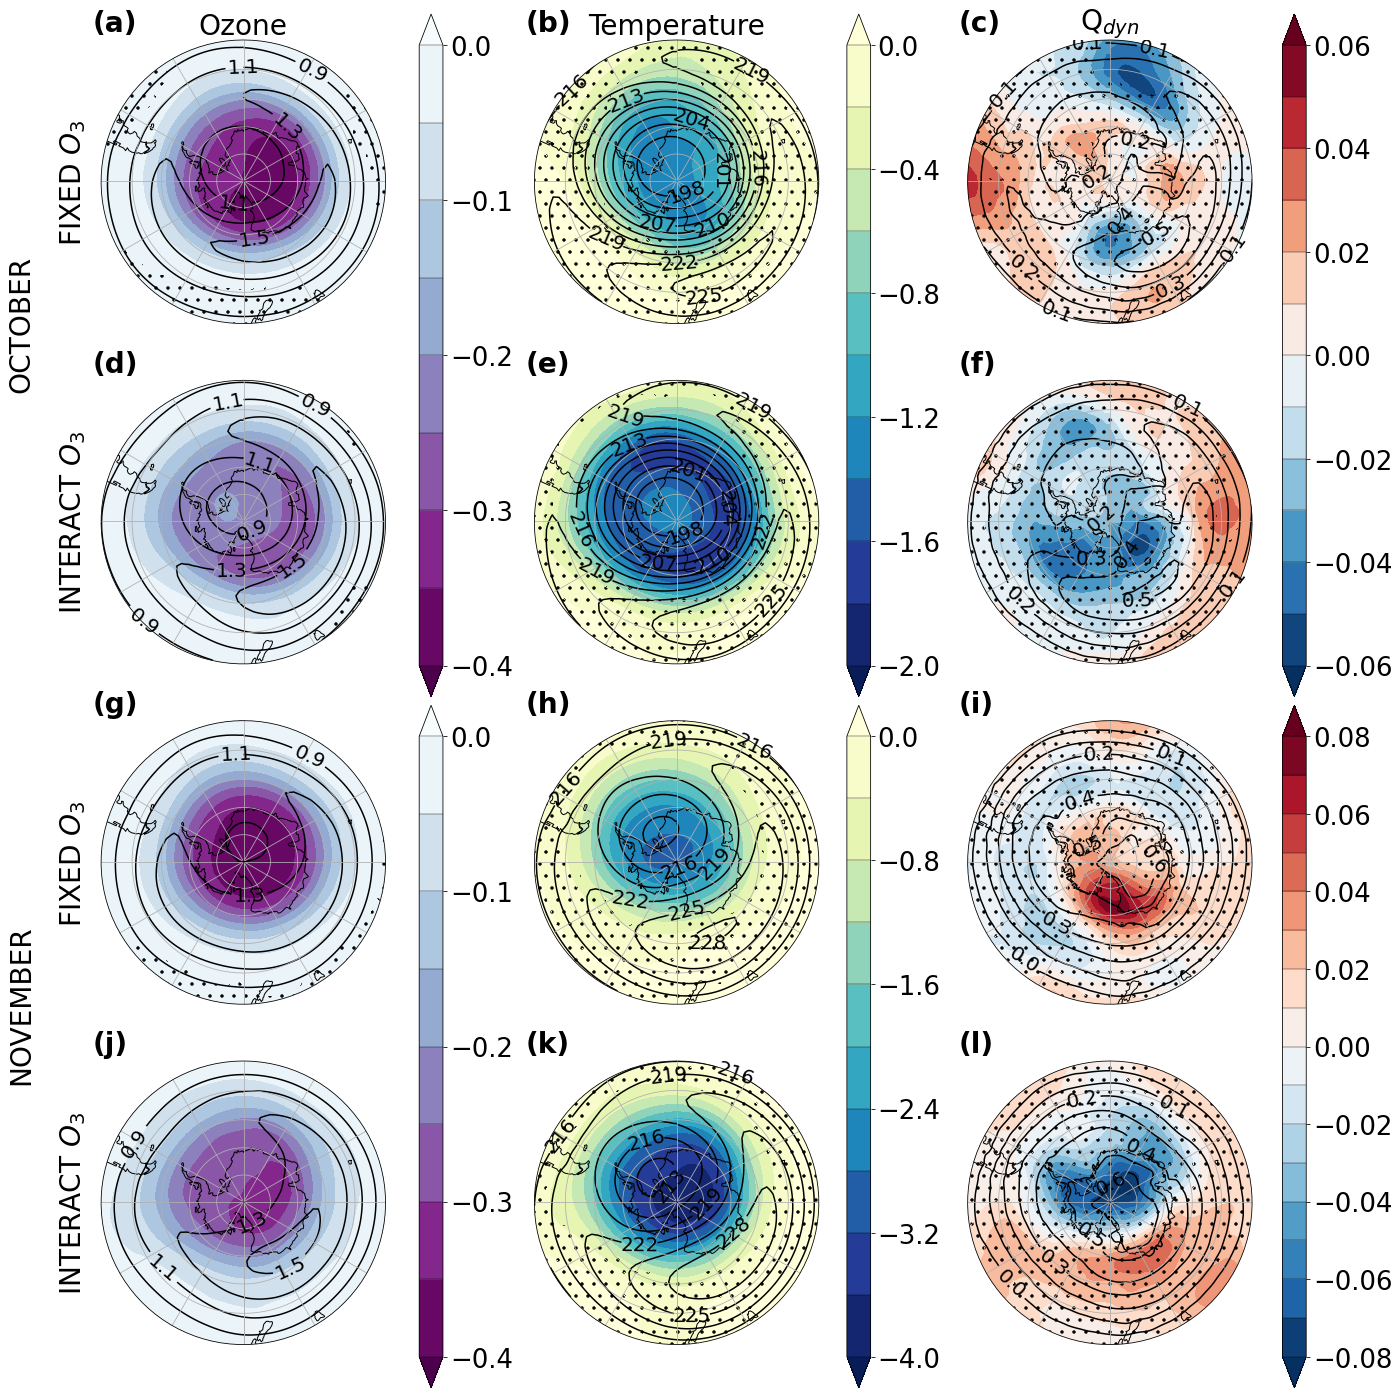

In [31]:
fig = plt.figure(figsize=(22,24))
#OCTOBER
# Ozone
cont = np.arange(-0.4, 0.01, 0.05)
cont2 = np.arange(0.9, 3.1, 0.2)

con, ax = plot_map_o(hist_trend.sel(plev=lev, lat=slice(-40,-90))[9,:,:], hist_sign.sel(plev=lev, lat=slice(-40,-90))[9,:,:], \
                hist_mean.sel(plev=lev, lat=slice(-40,-90))[9,:,:], cont,  cont2, 'Ozone', 1)
plt.text(-0.03,1.03, '(a)', fontsize=28, fontweight='bold', transform=ax.transAxes)
plt.text(-0.15, 0.5, 'FIXED $O_3$', fontsize=28, rotation=90, transform=ax.transAxes, va='center')
plt.text(-0.33, 0, 'OCTOBER', fontsize=28, rotation=90, transform=ax.transAxes, va='center')

con, ax = plot_map_o(moz_trend.sel(plev=lev, lat=slice(-40,-90))[9,:,:], moz_sign.sel(plev=lev, lat=slice(-40,-90))[9,:,:], \
                moz_mean.sel(plev=lev, lat=slice(-40,-90))[9,:,:], cont, cont2,  '', 4)
plt.text(-0.03,1.03, '(d)', fontsize=28, fontweight='bold', transform=ax.transAxes)

plt.text(-0.15, 0.5, 'INTERACT $O_3$', fontsize=28, rotation=90, transform=ax.transAxes, va='center')

ticks = np.arange(-0.6, 0.01, 0.1)
cax = plt.axes([0.35, 0.5, 0.015, 0.395])
c = plt.colorbar(con, cax=cax, ticks=ticks,  drawedges=True)
c.ax.tick_params(labelsize=26)

# Temperature
cont = np.arange(-2, 0.1, 0.2)
cont2 = np.arange(195, 230, 3)

con, ax = plot_map(hist_trend_t.sel(plev=lev, lat=slice(-40,-90))[9,:,:], hist_sign_t.sel(plev=lev, lat=slice(-40,-90))[9,:,:], \
                hist_mean_t.sel(plev=lev, lat=slice(-40,-90))[9,:,:], cont,  cont2, 'Temperature', 2)
plt.text(-0.03,1.03, '(b)', fontsize=28, fontweight='bold', transform=ax.transAxes)

con, ax = plot_map(moz_trend_t.sel(plev=lev, lat=slice(-40,-90))[9,:,:], moz_sign_t.sel(plev=lev, lat=slice(-40,-90))[9,:,:], \
                moz_mean_t.sel(plev=lev, lat=slice(-40,-90))[9,:,:], cont, cont2,  '', 5)
plt.text(-0.03,1.03, '(e)', fontsize=28, fontweight='bold', transform=ax.transAxes)

ticks = np.arange(-0.5, 0.01, 0.05)
cax = plt.axes([0.62, 0.5, 0.015, 0.395])
c = plt.colorbar(con, cax=cax,  drawedges=True)
c.ax.tick_params(labelsize=26)

#Q_dyn
cont = np.arange(-6, 7, 1)/100
cont2 = np.arange(0, 80, 10)/100
con, ax = plot_map_d(hist_trend_dyn.sel(plev=lev, lat=slice(-40,-90))[9,:,:], hist_sign_dyn.sel(plev=lev, lat=slice(-40,-90))[9,:,:], \
                hist_mean_dyn.sel(plev=lev, lat=slice(-40,-90))[9,:,:], cont,  cont2, 'Q$_{dyn}$', 3)
plt.text(-0.03,1.03, '(c)', fontsize=28, fontweight='bold', transform=ax.transAxes)

con, ax = plot_map_d(moz_trend_dyn.sel(plev=lev, lat=slice(-40,-90))[9,:,:], moz_sign_dyn.sel(plev=lev, lat=slice(-40,-90))[9,:,:], \
                moz_mean_dyn.sel(plev=lev, lat=slice(-40,-90))[9,:,:], cont, cont2,  '', 6)
plt.text(-0.03,1.03, '(f)', fontsize=28, fontweight='bold', transform=ax.transAxes)

ticks = np.arange(-6, 7, 2)/100
cax = plt.axes([0.895, 0.5, 0.015, 0.395])
c = plt.colorbar(con, cax=cax,  drawedges=True)
c.ax.tick_params(labelsize=26)

#NOVEMBER
# Ozone
cont = np.arange(-0.4, 0.01, 0.05)
cont2 = np.arange(0.9, 3.1, 0.2)

con, ax = plot_map_o(hist_trend.sel(plev=lev, lat=slice(-40,-90))[10,:,:], hist_sign.sel(plev=lev, lat=slice(-40,-90))[10,:,:], \
                hist_mean.sel(plev=lev, lat=slice(-40,-90))[10,:,:], cont,  cont2, '', 7)
plt.text(-0.03,1.03, '(g)', fontsize=28, fontweight='bold', transform=ax.transAxes)
plt.text(-0.15, 0.5, 'FIXED $O_3$', fontsize=28, rotation=90, transform=ax.transAxes, va='center')
plt.text(-0.33, 0, 'NOVEMBER', fontsize=28, rotation=90, transform=ax.transAxes, va='center')


con, ax = plot_map_o(moz_trend.sel(plev=lev, lat=slice(-40,-90))[10,:,:], moz_sign.sel(plev=lev, lat=slice(-40,-90))[10,:,:], \
                moz_mean.sel(plev=lev, lat=slice(-40,-90))[10,:,:], cont, cont2,  '', 10)
plt.text(-0.03,1.03, '(j)', fontsize=28, fontweight='bold', transform=ax.transAxes)

plt.text(-0.15, 0.5, 'INTERACT $O_3$', fontsize=28, rotation=90, transform=ax.transAxes, va='center')


ticks = np.arange(-0.6, 0.01, 0.1)
cax = plt.axes([0.35, 0.1, 0.015, 0.395])
c = plt.colorbar(con, cax=cax, ticks=ticks,  drawedges=True)
c.ax.tick_params(labelsize=26)

#plt.text(-6.5, -0.05, '$10^{-2}$ x', fontsize=26)

# Temperature
cont = np.arange(-4, 0.1, 0.4)
cont2 = np.arange(195, 230, 3)

con, ax = plot_map(hist_trend_t.sel(plev=lev, lat=slice(-40,-90))[10,:,:], hist_sign_t.sel(plev=lev, lat=slice(-40,-90))[10,:,:], \
                hist_mean_t.sel(plev=lev, lat=slice(-40,-90))[10,:,:], cont,  cont2, '', 8)
plt.text(-0.03,1.03, '(h)', fontsize=28, fontweight='bold', transform=ax.transAxes)

con, ax = plot_map(moz_trend_t.sel(plev=lev, lat=slice(-40,-90))[10,:,:], moz_sign_t.sel(plev=lev, lat=slice(-40,-90))[10,:,:], \
                moz_mean_t.sel(plev=lev, lat=slice(-40,-90))[10,:,:], cont, cont2,  '', 11)
plt.text(-0.03,1.03, '(k)', fontsize=28, fontweight='bold', transform=ax.transAxes)

ticks = np.arange(-0.5, 0.01, 0.05)
cax = plt.axes([0.62, 0.1, 0.015, 0.395])
c = plt.colorbar(con, cax=cax,  drawedges=True)
c.ax.tick_params(labelsize=26)

#Q_dyn
cont = np.arange(-8, 9, 1)/100
cont2 = np.arange(0, 80, 10)/100
con, ax = plot_map_d(hist_trend_dyn.sel(plev=lev, lat=slice(-40,-90))[10,:,:], hist_sign_dyn.sel(plev=lev, lat=slice(-40,-90))[10,:,:], \
                hist_mean_dyn.sel(plev=lev, lat=slice(-40,-90))[10,:,:], cont,  cont2, '', 9)
plt.text(-0.03,1.03, '(i)', fontsize=28, fontweight='bold', transform=ax.transAxes)

con, ax = plot_map_d(moz_trend_dyn.sel(plev=lev, lat=slice(-40,-90))[10,:,:], moz_sign_dyn.sel(plev=lev, lat=slice(-40,-90))[10,:,:], \
                moz_mean_dyn.sel(plev=lev, lat=slice(-40,-90))[10,:,:], cont, cont2,  '', 12)
plt.text(-0.03,1.03, '(l)', fontsize=28, fontweight='bold', transform=ax.transAxes)

ticks = np.arange(-8, 9, 2)/100
cax = plt.axes([0.895, 0.1, 0.015, 0.395])
c = plt.colorbar(con, cax=cax,  drawedges=True)
c.ax.tick_params(labelsize=26)

In [32]:
def plot_map2(trend, sign, mean, cont, cont2, title,n):
    
    lat = trend.lat
    lon = trend.lon
    lon2, lat2 = np.meshgrid(np.append(lon,[360]), np.append(lat,[-90]))
    
    # Define circle to have a round boundary to the plot
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    trend = np.pad(trend, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    sign = np.pad(sign, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    mean = np.pad(mean, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    
    ax = fig.add_subplot(2,2,n, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180,180,-90,-40], ccrs.PlateCarree()) # needs to be PlateCarree
    ax.add_feature(cf.COASTLINE)
    gl = ax.gridlines(ccrs.PlateCarree()) # needs to be PlateCarree
    gl.xlocator = mticker.FixedLocator([180, 150, 120, 90, 60, 30, 0, -30, -60, -90, -120, -150, -180])
    gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -20])
    gl.n_steps = 100 # without it the paralels are drwan too coarse and are polygons rather than circles
    ax.set_boundary(circle, transform=ax.transAxes) # creates round boundary

    con=ax.contourf(lon2 ,lat2, trend, cont, transform=ccrs.PlateCarree(), cmap='YlGnBu_r', extend='both', hatches=['.'])
    con=ax.contourf(lon2 ,lat2, sign, cont, transform=ccrs.PlateCarree(), cmap='YlGnBu_r', extend='both')
    #cs=ax.contour(lon2, lat2, mean, cont2, transform=ccrs.PlateCarree(), colors='k')
    #plt.clabel(cs, fmt= '%1.1f', fontsize=16, inline=1)
    plt.title(title, fontsize=28)
    
    return con, ax

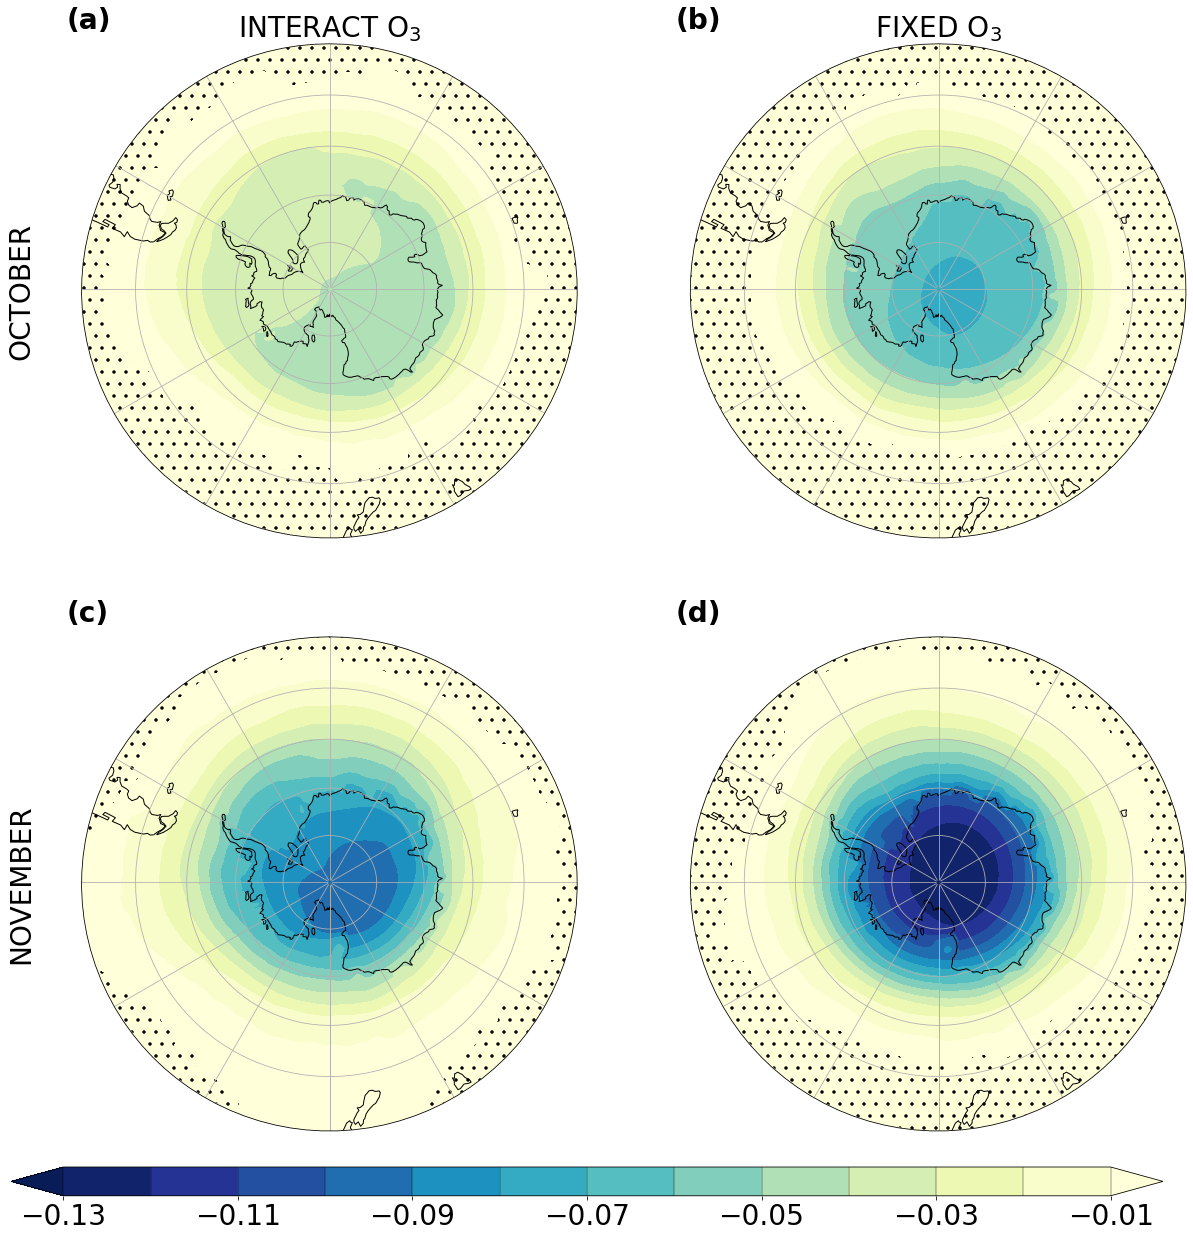

In [33]:
fig = plt.figure(figsize=(20,20))
cont = np.arange(-13, -0.5, 1)/100
cont2 = np.arange(195, 230, 3)
#OCTOBER
con, ax = plot_map2(moz_trend_sw.sel(plev=lev, lat=slice(-40,-90))[9,:,:], moz_sign_sw.sel(plev=lev,lat=slice(-40,-90))[9,:,:], \
                moz_mean_sw.sel(plev=lev,lat=slice(-40,-90))[9,:,:], cont,  10, 'INTERACT O$_3$', 1)
plt.text(-0.03,1.03, '(a)', fontsize=28, fontweight='bold', transform=ax.transAxes)
plt.text(-0.15, 0.5, 'OCTOBER', fontsize=28, rotation=90, transform=ax.transAxes, va='center')

con, ax = plot_map2(hist_trend_sw.sel(plev=lev,lat=slice(-40,-90))[9,:,:], hist_sign_sw.sel(plev=lev,lat=slice(-40,-90))[9,:,:], \
                hist_mean_sw.sel(plev=lev,lat=slice(-40,-90))[9,:,:], cont, 10,  'FIXED O$_3$', 2)
plt.text(-0.03,1.03, '(b)', fontsize=28, fontweight='bold', transform=ax.transAxes)
#NOVEMBER
con, ax = plot_map2(moz_trend_sw.sel(plev=lev, lat=slice(-40,-90))[10,:,:], moz_sign_sw.sel(plev=lev,lat=slice(-40,-90))[10,:,:], \
                moz_mean_sw.sel(plev=lev,lat=slice(-40,-90))[10,:,:], cont,  10, '', 3)
plt.text(-0.03,1.03, '(c)', fontsize=28, fontweight='bold', transform=ax.transAxes)
plt.text(-0.15, 0.5, 'NOVEMBER', fontsize=28, rotation=90, transform=ax.transAxes, va='center')

con, ax = plot_map2(hist_trend_sw.sel(plev=lev,lat=slice(-40,-90))[10,:,:], hist_sign_sw.sel(plev=lev,lat=slice(-40,-90))[10,:,:], \
                hist_mean_sw.sel(plev=lev,lat=slice(-40,-90))[10,:,:], cont, 10,  '', 4)
plt.text(-0.03,1.03, '(d)', fontsize=28, fontweight='bold', transform=ax.transAxes)

ticks = np.arange(-0.5, 0.01, 0.05)
cax = plt.axes([0.08, 0.08, 0.8, 0.02])
c = plt.colorbar(con, cax=cax,  orientation='horizontal', drawedges=True)
c.ax.tick_params(labelsize=28)

In [34]:
def plot_map6(trend, sign, mean, cont, cont2, title,n,let):
    
    lat = trend.lat
    lon = trend.lon
    lon2, lat2 = np.meshgrid(np.append(lon,[360]), np.append(lat,[-90]))
    
    # Define circle to have a round boundary to the plot
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    trend = np.pad(trend, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    sign = np.pad(sign, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    mean = np.pad(mean, ((0,1), (0,1)), 'edge') # pad with the last row and column to get rid of the white space in the plot
    
    ax = fig.add_subplot(2,3,n, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180,180,-90,-40], ccrs.PlateCarree()) # needs to be PlateCarree
    ax.add_feature(cf.COASTLINE)
    gl = ax.gridlines(ccrs.PlateCarree()) # needs to be PlateCarree
    gl.xlocator = mticker.FixedLocator([180, 150, 120, 90, 60, 30, 0, -30, -60, -90, -120, -150, -180])
    gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -20])
    gl.n_steps = 100 # without it the paralels are drwan too coarse and are polygons rather than circles
    ax.set_boundary(circle, transform=ax.transAxes) # creates round boundary

    con=ax.contourf(lon2 ,lat2, trend, cont, transform=ccrs.PlateCarree(), cmap='YlGnBu_r', extend='both', hatches=['.'])
    con=ax.contourf(lon2 ,lat2, sign, cont, transform=ccrs.PlateCarree(), cmap='YlGnBu_r', extend='both')
    cs=ax.contour(lon2, lat2, mean, cont2, transform=ccrs.PlateCarree(), colors='k')
    plt.clabel(cs, fmt= '%1.0f', fontsize=16, inline=1)
    plt.title(title, fontsize=28)
    plt.text(-0.03,1.03, let, fontsize=28, fontweight='bold', transform=ax.transAxes)
    
    return con

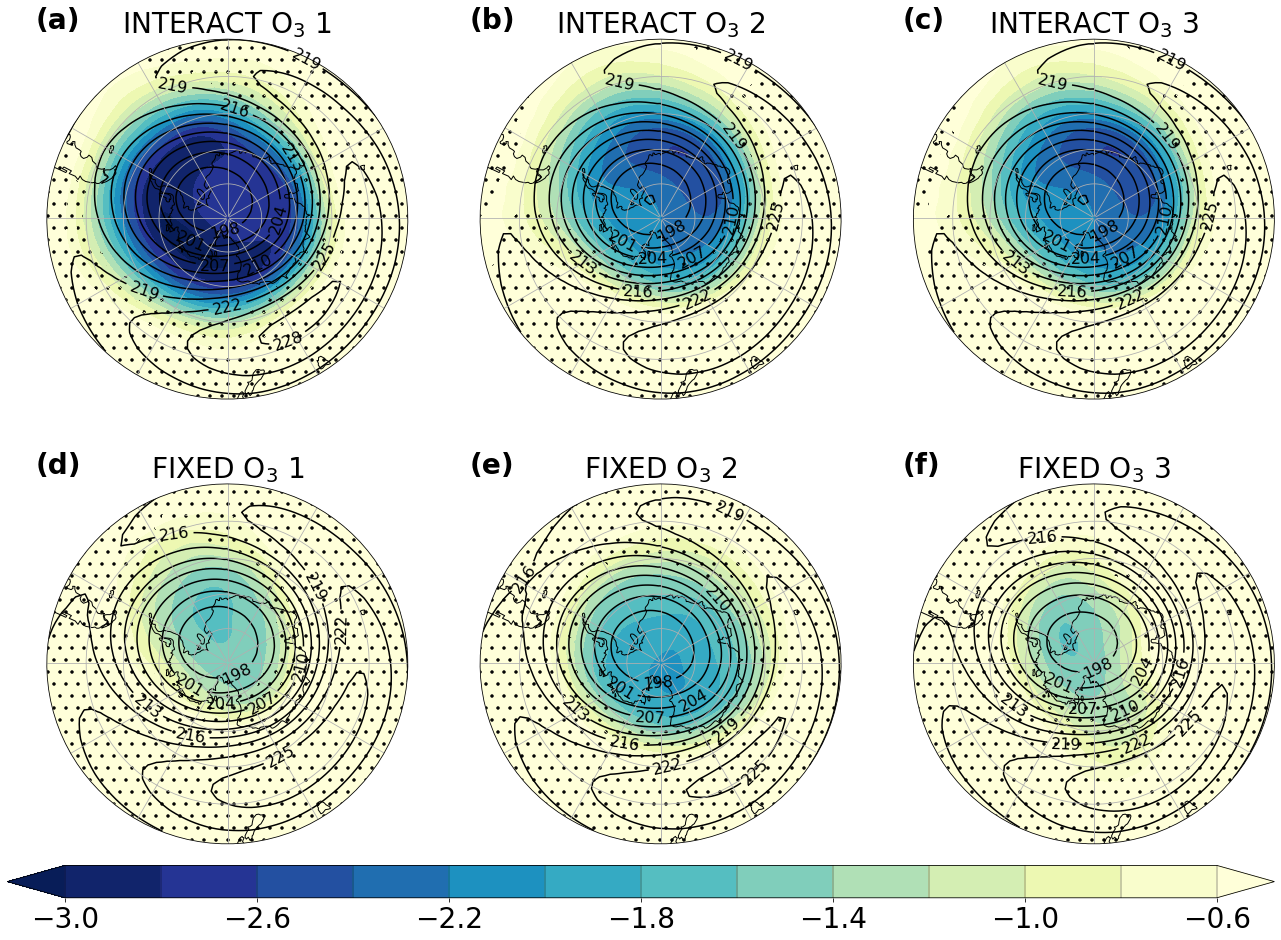

In [37]:
fig = plt.figure(figsize=(22,15))
cont = np.arange(-3, -0.5, 0.2)
cont2 = np.arange(195, 230, 3)

con = plot_map6(sw054_trend_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], sw054_sign_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], \
                sw054_mean_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], cont,  cont2, 'INTERACT O$_3$ 1', 1, '(a)')
con = plot_map6(sw064_trend_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], sw064_sign_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], \
                sw064_mean_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], cont, cont2,  'INTERACT O$_3$ 2', 2,'(b)')
con = plot_map6(sw064_trend_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], sw064_sign_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], \
                sw064_mean_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], cont, cont2,  'INTERACT O$_3$ 3', 3,'(c)')

con = plot_map6(sw060_trend_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], sw060_sign_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], \
                sw060_mean_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], cont, cont2,  'FIXED O$_3$ 1', 4,'(d)')
con = plot_map6(sw061_trend_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], sw061_sign_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], \
                sw061_mean_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], cont, cont2,  'FIXED O$_3$ 2', 5,'(e)')
con = plot_map6(jh019_trend_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], jh019_sign_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], \
                jh019_mean_t.sel(lat=slice(-40,-90), plev=7000)[9,:,:], cont, cont2,  'FIXED O$_3$ 3', 6,'(f)')

ticks = np.arange(-0.5, 0.01, 0.05)
cax = plt.axes([0.1, 0.08, 0.8, 0.03])
c = plt.colorbar(con, cax=cax,  orientation='horizontal', drawedges=True)
c.ax.tick_params(labelsize=28)